Part of the ensemble used for getting 17th place in Zero to GANs - Human Protein Classification competition.
More about the competition:
https://www.kaggle.com/c/jovian-pytorch-z2g/overview

In [1]:

from fastai2.vision.all import *
matplotlib.rc('image', cmap='Greys')

In [2]:
train_csv = pd.read_csv('data/train.csv')

In [3]:
train_csv.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


In [4]:
def get_x(r): return Path("data/train/"+str(r['Image'])+'.png')
def get_y(r): return r['Label'].split(' ')

In [5]:

def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y,
                   batch_tfms=[*aug_transforms(flip_vert=False,size=size, min_scale=0.8),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(train_csv, bs=bs)

In [6]:
dls = get_dls(128,128)

/home/zeldax/.local/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


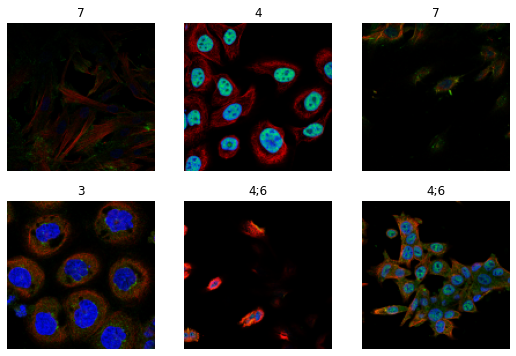

In [7]:
dls.show_batch(nrows=2, ncols=3)

In [8]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [9]:
def F_score(output, label, threshold=0.2, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [10]:
learn = cnn_learner(dls, resnet50, metrics=[partial(accuracy_multi, thresh=0.5),partial(F_score, threshold=0.5)]).to_fp16()


SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.033113110810518265)

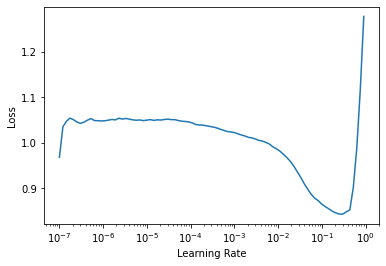

In [11]:
learn.lr_find()

In [12]:
learn.fine_tune(10, 3e-2,4)

epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.481003,0.353434,0.868677,0.226626,00:30
1,0.367526,0.337488,0.873694,0.332498,00:29
2,0.327055,0.306877,0.880972,0.249879,00:30
3,0.309430,0.297055,0.885469,0.398487,00:30


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.291675,0.293216,0.888173,0.443499,00:36
1,0.286319,0.299512,0.880660,0.438671,00:36
2,0.281776,0.302623,0.885079,0.482459,00:36
3,0.273578,0.296041,0.893761,0.525467,00:36
4,0.265231,0.266299,0.897661,0.506111,00:36
5,0.253768,0.257923,0.900468,0.545557,00:36
6,0.244660,0.245231,0.906395,0.542660,00:36
7,0.234303,0.249406,0.903717,0.539905,00:36
8,0.224108,0.240939,0.907408,0.595844,00:36
9,0.219396,0.236285,0.909436,0.586380,00:36


In [13]:
learn.export('128_res50_export.pkt')

In [14]:
learn.dls = get_dls(32, 256)

In [15]:
learn.fine_tune(15, 1e-2,5)

epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.238034,0.227187,0.909358,0.602664,01:15
1,0.227142,0.224917,0.911827,0.620746,01:14
2,0.225711,0.213710,0.915934,0.652460,01:14
3,0.226308,0.212086,0.916792,0.667084,01:14
4,0.224770,0.212531,0.918222,0.678052,01:12


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.211097,0.204023,0.920301,0.652287,01:33
1,0.213517,0.203053,0.920691,0.660672,01:32
2,0.212673,0.211221,0.917546,0.663326,01:32
3,0.211886,0.232779,0.909072,0.639514,01:33
4,0.213913,0.207655,0.919366,0.671423,01:33
5,0.203804,0.201017,0.923005,0.698310,01:33
6,0.197939,0.211767,0.917884,0.672604,01:32
7,0.189231,0.206191,0.919002,0.694442,01:33
8,0.191856,0.193331,0.924746,0.709610,01:33
9,0.179836,0.185283,0.927502,0.704459,01:33


In [16]:
learn.export('256_res50_export.pkt')

In [17]:
learn.dls = get_dls(8, 512)
learn.fine_tune(15, 3e-3,4)

epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.224465,0.378545,0.865193,0.475730,04:27
1,0.205235,0.318855,0.880322,0.568240,04:25
2,0.220221,0.361821,0.869873,0.536445,04:25
3,0.209916,0.262064,0.900286,0.602491,04:27


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.195082,0.278918,0.899636,0.623273,05:56
1,0.206876,0.250240,0.906083,0.625508,05:50
2,0.197082,0.240169,0.910138,0.620789,05:50
3,0.192964,0.274178,0.889498,0.623308,05:50
4,0.202201,0.223681,0.913179,0.646634,05:51
5,0.189650,0.203959,0.921419,0.659267,05:50
6,0.193713,0.243862,0.899974,0.652512,05:50
7,0.184346,0.222656,0.912217,0.657626,05:50
8,0.177584,0.231846,0.911983,0.645155,05:51
9,0.172856,0.222868,0.916585,0.667150,05:54


In [18]:

learn.export('512_res50_export.pkt')

In [19]:
#test treshikd
learn.metrics = partial(F_score, threshold=0.2)
learn.validate()

(#2) [0.22839270532131195,0.7038040161132812]

In [20]:
#test treshikd
learn.metrics = partial(F_score, threshold=0.25)
learn.validate()

(#2) [0.22839270532131195,0.700942873954773]

In [21]:
#test treshikd
learn.metrics = partial(F_score, threshold=0.3)
learn.validate()

(#2) [0.22839270532131195,0.696078896522522]

In [22]:
#test treshikd
learn.metrics = partial(F_score, threshold=0.35)
learn.validate()

(#2) [0.22839270532131195,0.6896621584892273]

In [23]:
learn.dls = get_dls(8, 512)
learn.fine_tune(10, 3e-3,1)

epoch,train_loss,valid_loss,F_score,time
0,0.183767,0.218020,0.685819,04:25


epoch,train_loss,valid_loss,F_score,time
0,0.186981,0.193747,0.718404,05:49
1,0.185353,0.206810,0.671248,05:49
2,0.182094,0.206223,0.723808,05:50
3,0.192532,0.200369,0.684721,05:50
4,0.177827,0.191839,0.718392,05:50
5,0.171751,0.224850,0.692786,05:50
6,0.174489,0.216835,0.697314,05:50
7,0.157234,0.204449,0.714351,05:50
8,0.164185,0.194874,0.723232,05:50
9,0.152977,0.208454,0.713625,05:50


In [24]:
learn.export('512_res50_export_10.pkt')

In [57]:
learn.dls = get_dls(16, 512)
learn.fine_tune(4, 3e-4,1)

epoch,train_loss,valid_loss,F_score,time
0,0.148556,0.193327,0.736318,03:57


epoch,train_loss,valid_loss,F_score,time
0,0.144397,0.182603,0.752488,05:05
1,0.144725,0.187774,0.755831,05:03
2,0.142896,0.187860,0.742724,05:03
3,0.139112,0.188243,0.750194,05:04


In [58]:
#test treshikd
learn.metrics = partial(F_score, threshold=0.2)
learn.validate()

(#2) [0.1882432997226715,0.7589552998542786]

In [26]:
#test treshikd
learn.metrics = partial(F_score, threshold=0.25)
learn.validate()

(#2) [0.20845448970794678,0.7187232971191406]

In [59]:
#test treshikd
learn.metrics = partial(F_score, threshold=0.3)
learn.validate()

(#2) [0.1882432997226715,0.7543137073516846]

In [28]:
#test treshikd
learn.metrics = partial(F_score, threshold=0.35)
learn.validate()

(#2) [0.20845448970794678,0.7136251330375671]

In [60]:

preds,targs = learn.tta()

In [61]:
F_score(preds, targs, threshold=0.4)

tensor(0.8555)

In [62]:
test_df =  pd.read_csv('submission.csv')
test_df.head()

,Image,Label
0,24117,0
1,15322,0
2,14546,0
3,8079,0
4,13192,0


In [63]:
dl = learn.dls.test_dl(test_df)

In [64]:
preds,targs = learn.tta(dl=dl)

In [65]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [82]:
predictions = [decode_target(x, threshold=0.31) for x in preds]

In [83]:
submission_df = pd.read_csv('submission.csv')
submission_df.Label = predictions
submission_df.head()

,Image,Label
0,24117,4 8
1,15322,4
2,14546,6
3,8079,0 3 6
4,13192,3 4


In [84]:
sub_fname = 'submission_512_res50_score_855_31.csv'
submission_df.to_csv(sub_fname, index=False)

In [85]:
learn.dls = get_dls(16, 512)
learn.fine_tune(2, 4e-5,1)

epoch,train_loss,valid_loss,F_score,time
0,0.132301,0.194974,0.749724,03:57


epoch,train_loss,valid_loss,F_score,time
0,0.137562,0.194315,0.752797,05:09
1,0.142569,0.183692,0.759067,05:10


In [86]:
preds,targs = learn.tta()

In [90]:
F_score(preds, targs, threshold=0.37)

tensor(0.8626)

In [91]:
preds,targs = learn.tta(dl=dl)

In [109]:
predictions = [decode_target(x, threshold=0.31) for x in preds]

In [110]:
submission_df = pd.read_csv('submission.csv')
submission_df.Label = predictions
submission_df.head()

,Image,Label
0,24117,4 8
1,15322,4
2,14546,6
3,8079,0 6
4,13192,3 4


In [111]:
sub_fname = 'submission_512_res50_score_8526_31.csv'
submission_df.to_csv(sub_fname, index=False)

In [112]:
learn.export('submission_512_res50_score_8526_31.pkt')